In [8]:
!pip install tensorflow opencv-python matplotlib scikit-learn


In [26]:
import zipfile
import os

# 압축 파일 경로와 해제할 디렉터리 경로
zip_file_path = './archive (2).zip'
extracted_dir_path = './dataset2/'

# 압축 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# 해제된 파일의 디렉토리 구조 확인
for root, dirs, files in os.walk(extracted_dir_path):
    print(root, len(dirs), len(files))


./dataset2/ 3 0
./dataset2/yes 0 155
./dataset2/brain_tumor_dataset 2 0
./dataset2/brain_tumor_dataset/yes 0 155
./dataset2/brain_tumor_dataset/no 0 98
./dataset2/no 0 98


Found 5276 images belonging to 3 classes.
Found 1318 images belonging to 3 classes.


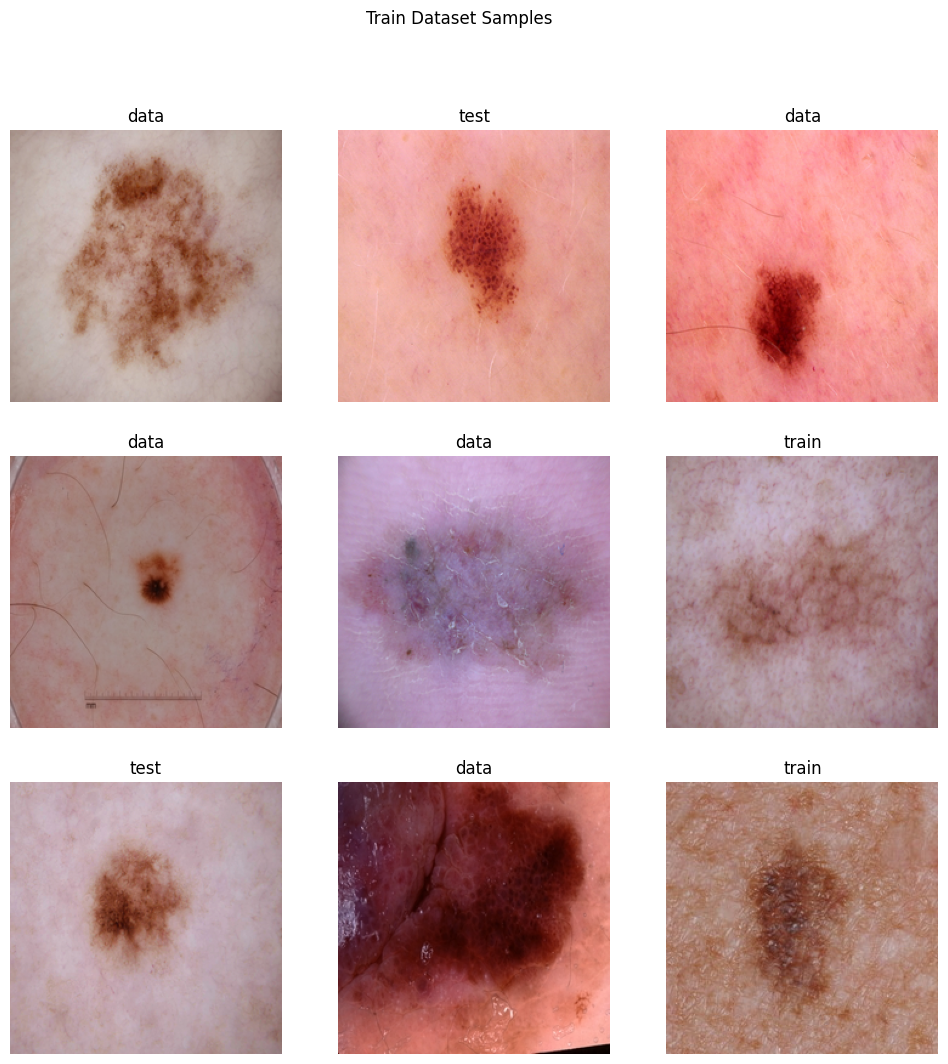

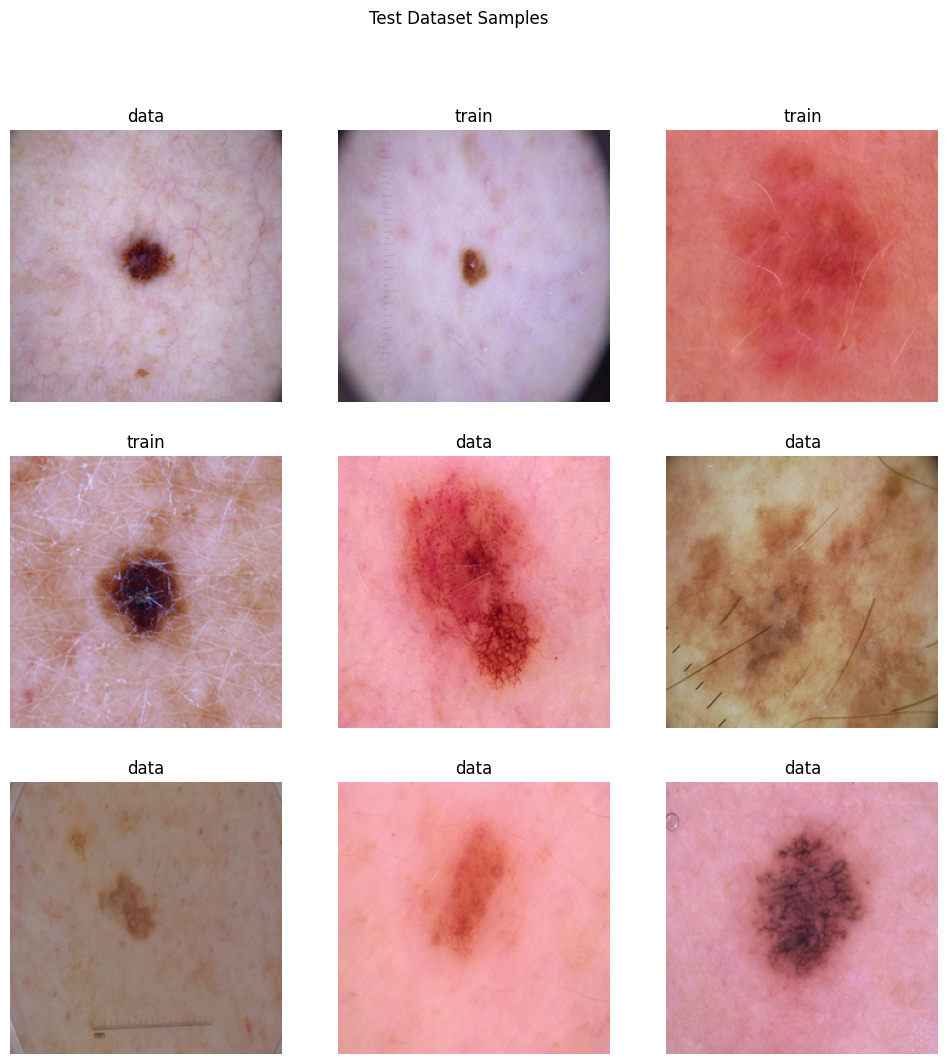

In [33]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = './dataset'

# Image Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Visualize some images from the train and validation datasets
def plot_images(generator, title):
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.figure(figsize=(12, 12))
    for i in range(9):
        img, label = next(generator)
        plt.subplot(3, 3, i+1)
        plt.imshow(img[0])
        plt.title(class_names[int(label[0])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_generator, 'Train Dataset Samples')
plot_images(validation_generator, 'Test Dataset Samples')

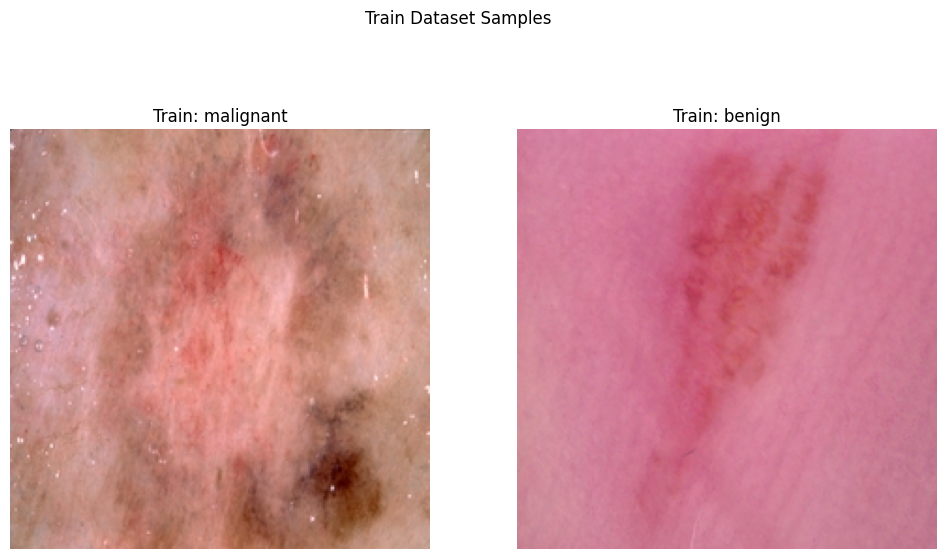

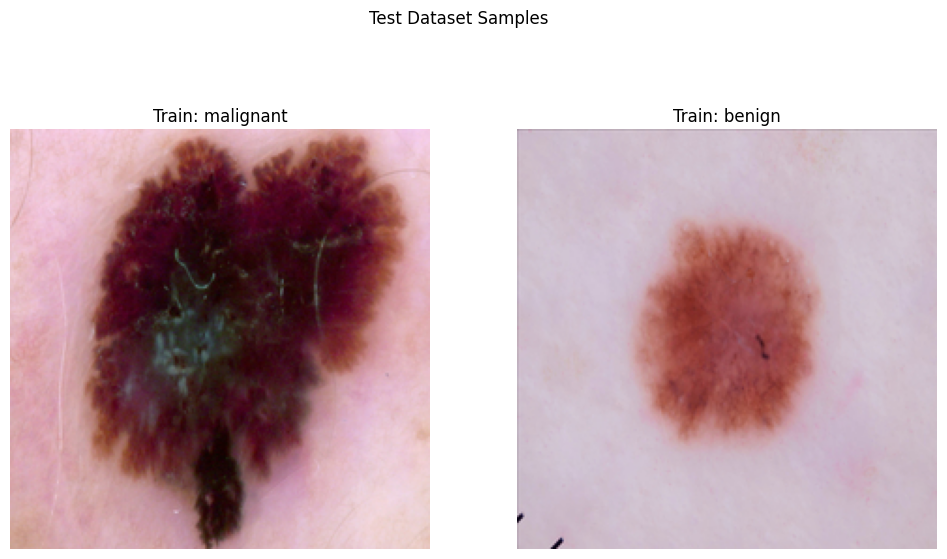

In [36]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
train_dir = './dataset/train'
test_dir = './dataset/test'

# Function to plot images from a directory
def plot_images_from_directory(directory, title):
    class_names = os.listdir(directory)
    num_classes = len(class_names)

    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Take the first image from each class
        img = load_img(image_path, target_size=(224, 224))
        plt.subplot(2, num_classes, i + 1)
        plt.imshow(img)
        plt.title(f'Train: {class_name}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize train dataset
plot_images_from_directory(train_dir, 'Train Dataset Samples')

# Visualize test dataset
plot_images_from_directory(test_dir, 'Test Dataset Samples')


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [45]:
# Define paths
train_dir = './dataset/train'
test_dir = './dataset/test'

# Image Data Generators with Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [47]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build the model
model = build_cnn_model(input_shape=(224, 224, 3))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,158,913 (8.24 MB)

 Trainable params: 2,158,913 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-4]:  # 마지막 4개 층을 제외한 모든 층을 고정
    layer.trainable = False

# Use the Functional API to build the model
inputs = base_model.input
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)  # Create a Functional model

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 472ms/step - accuracy: 0.8628 - loss: 0.2982 - val_accuracy: 0.8394 - val_loss: 0.3697
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - accuracy: 0.8550 - loss: 0.3255 - val_accuracy: 0.8591 - val_loss: 0.3166
Epoch 3/30
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5:13 4s/step - accuracy: 0.8750 - loss: 0.2468

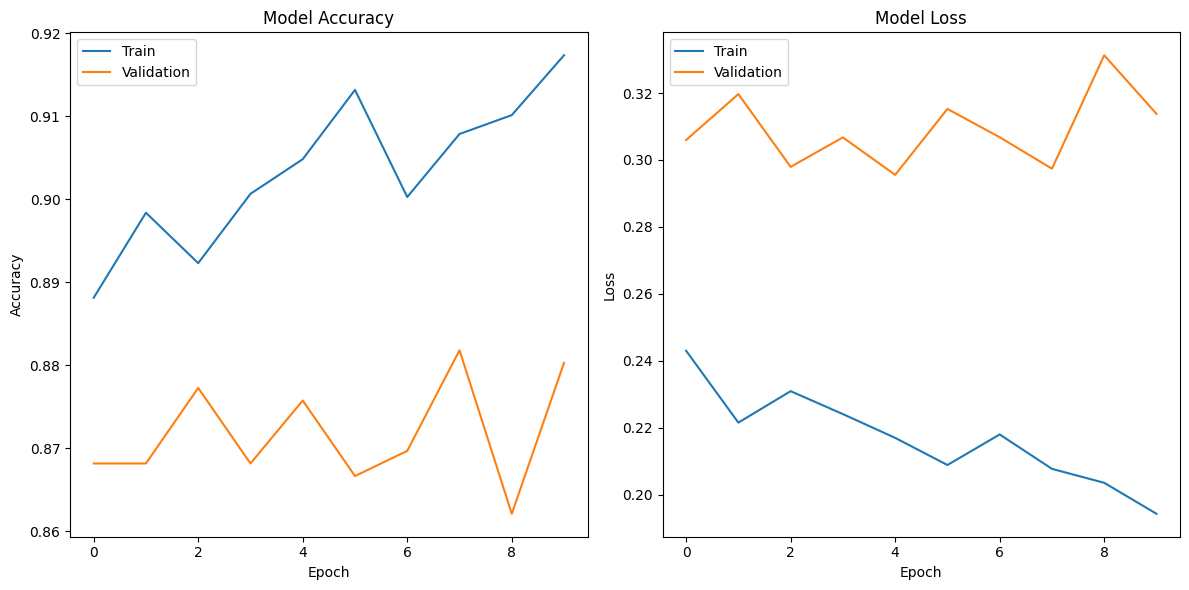

In [55]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [52]:
model.save('model_3.h5')